다음의 내장 툴을 활용
- 사칙 연산 
- Gmail (서치, 센딩 등)
- arXiv 논문 검색
- create_retriever_tools

In [31]:
from dotenv import load_dotenv

load_dotenv()

True

In [32]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

small_llm = ChatOpenAI(model='gpt-4o-mini')


In [33]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

In [34]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

In [35]:
from langchain_google_community import GmailToolkit

from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)

credentials = get_gmail_credentials(
    token_file="./google/gmail_token.json",
    scopes=["https://mail.google.com/"],
    client_secrets_file="./google/gmail_credentials.json",
)
api_resource = build_resource_service(credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolkit.get_tools()

'''
gmail_tool_list은 다음과 같은 기능을 지님.
[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x13a332780>),
 GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x13a332780>),
 GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x13a332780>),
 GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x13a332780>),
 GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x13a332780>)]
'''

'\ngmail_tool_list은 다음과 같은 기능을 지님.\n[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x13a332780>),\n GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x13a332780>),\n GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x13a332780>),\n GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x13a332780>),\n GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x13a332780>)]\n'

In [36]:
from langchain.agents import load_tools

loaded_tool_list = load_tools(
    ["arxiv"]
)

In [37]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply, search_tool] + gmail_tool_list + loaded_tool_list
llm_with_tools = llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [38]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [39]:
def agent(state: MessagesState) -> MessagesState:
    
    '''
    에이전트 함수는 주어진 상태에서 메시지를 가져와
    LLM과 도구를 사용하여 응답 메시지를 생성합니다.

    Args:
        state (MessagesState): 메시지 상태를 포함하는 state.

    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state.
    '''

    messages = state['messages']    #1  메세지 추출
    response = llm_with_tools.invoke(messages)  #2 LLM & 도구 → 메세치 처리 및 응답 생성
    return {'messages': [response]} #3 새로운 응답 메세지 반환

In [40]:
def should_continue(state: MessagesState):
    messages = state['messages']    #1 메세지 추출
    last_ai_message = messages[-1]  #2 AiMessage 가져와서 
    if last_ai_message.tool_calls:     
        return 'tools'  #3 도구 호출 포함 여부로부터, 'tools' || 'END' 반환
    return 'end'

In [41]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node) 

In [42]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    {
        'tools': 'tools',
        'end': END
    }
)
graph_builder.add_edge('tools', 'agent')

In [43]:
graph = graph_builder.compile()

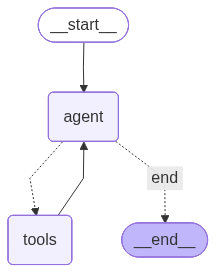

In [44]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [45]:
from langchain_core.messages import HumanMessage

query = 'Attention Is All You Need라는 논문을 요약헤서 1839sh@gmail.com으로 메일 보내주세요.'
for chunk in graph.stream({'messages': [HumanMessage(query)]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

Attention Is All You Need라는 논문을 요약헤서 1839sh@gmail.com으로 메일 보내주세요.
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_TlSwZTT6HjSwilFcb4AMNs7H)
 Call ID: call_TlSwZTT6HjSwilFcb4AMNs7H
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2021-05-06
Title: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet
Authors: Luke Melas-Kyriazi
Summary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifically, we replace the attention layer in